In [1]:
import lightgbm as lgb
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

from mlforecast import MLForecast
from mlforecast.utils import PredictionIntervals
from utils.prep import Naive, LagFeatureAdder
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, coverage

In [2]:

#load data
df_values = pd.read_parquet("data/hm").reset_index(drop=True)
df_static = pd.read_parquet("data/static").reset_index(drop=True)
df_dynamic = pd.read_parquet("data/dynamic").reset_index(drop=True)

#set default column names
df_values = df_values.rename(columns={'time': 'ds', 'hm': 'y', 'z': 'unique_id'})
df_static = df_static.rename(columns={'z': 'unique_id'})
df_dynamic = df_dynamic.rename(columns={'time': 'ds', 'z': 'unique_id'})

# Extract year from ds, subtract 1990, and divide by 5
df_values['ds'] = pd.to_datetime(df_values['ds']).dt.year
df_values['ds'] = ((df_values['ds'] - 1990) / 5).astype(int)
df_dynamic['ds'] = pd.to_datetime(df_dynamic['ds']).dt.year
df_dynamic['ds'] = ((df_dynamic['ds'] - 1990) / 5).astype(int)

#combine hm vals and static
df_values = df_values.merge(df_static, on='unique_id', how='left')
#combine dynamic into vals
df_values = df_values.merge(df_dynamic, on=['unique_id', 'ds'], how='left')
#drop rows with nan in any column
df_values = df_values.dropna()

# Create lag 1 value
df_values['lag1'] = df_values.sort_values(by=['unique_id', 'ds']).groupby('unique_id')['y'].shift(1)
#group by h3 and ds and cal mean of lag 1
df_values['lag1_mean'] = df_values.groupby(['h3_index', 'ds'])['lag1'].transform('mean')
#group by unique_id and ds get first h3_index
df_ind = df_values.groupby(['unique_id']).first().reset_index()[['unique_id', 'h3_index']]

#drop cols
df_values = df_values.drop(columns=['latitude', 'longitude','h3_index','lag1'])
#drop ds >4 to get data up to 2010. we will compare with predictions for 2015 and 2020
df_values_small = df_values[df_values['ds'] <= 4]


# fit and validate

In [3]:
models = [Naive(), lgb.LGBMRegressor(n_jobs=1, random_state=0, verbosity=-1)]

fcst = MLForecast(
    models=models,
    freq=1,
    lags=[1,2]
)
fcst.fit(df_values_small, static_features=['elevation','AG', 'BU', 'HI', 'PO', 'EX', 'FR', 'TI', 'NS',
                                  'sh_0', 'sh_1', 'sh_2', 'sh_3','sh_4', 'sh_5', 'sh_6', 'sh_7', 'sh_8'],
                                  prediction_intervals=PredictionIntervals(n_windows=2, h=1))

MLForecast(models=[Naive, LGBMRegressor], freq=1, lag_features=['lag1', 'lag2'], date_features=[], num_threads=1)

In [8]:
#print the order of the features
#fcst.ts.features_order_

In [4]:
#get original ids
ids = pd.Series(fcst.ts.uids)
lfa = LagFeatureAdder(df_ind, ids)

#filter df_dynamic to only include unique_ids in df_values
unique_ids = df_values_small['unique_id'].unique()
df_dynamic = df_dynamic[df_dynamic['unique_id'].isin(unique_ids)]
df_dynamic['lag1_mean'] = np.nan
df_dynamic

,ds,unique_id,gdp,lag1_mean
82,0,82,0.0,NaN
83,0,83,0.0,NaN
84,0,84,5341528.5,NaN
85,0,85,5341528.5,NaN
86,0,86,5341528.5,NaN
...,...,...,...,...
1167745,4,122512,0.0,NaN
1167746,4,122513,0.0,NaN
1167747,4,122514,0.0,NaN
1167748,4,122515,0.0,NaN


In [5]:
#predict
preds = fcst.predict(h=2, X_df=df_dynamic, level=[95],before_predict_callback=lfa.add_lag_features)
preds



/Users/glen.moncrieff/mambaforge/envs/earthmover/lib/python3.12/site-packages/mlforecast/core.py:625: UserWarning: Found null values in lag1_mean.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
/Users/glen.moncrieff/mambaforge/envs/earthmover/lib/python3.12/site-packages/mlforecast/core.py:625: UserWarning: Found null values in lag1_mean.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
/Users/glen.moncrieff/mambaforge/envs/earthmover/lib/python3.12/site-packages/mlforecast/core.py:625: UserWarning: Found null values in lag1_mean.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')


0
0
0


/Users/glen.moncrieff/mambaforge/envs/earthmover/lib/python3.12/site-packages/mlforecast/core.py:625: UserWarning: Found null values in lag1_mean.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')


0


/Users/glen.moncrieff/mambaforge/envs/earthmover/lib/python3.12/site-packages/mlforecast/forecast.py:770: UserWarning: Prediction intervals are calculated using 1-step ahead cross-validation, with a constant width for all horizons. To vary the error by horizon, pass PredictionIntervals(h=h) to the `prediction_intervals` argument when refitting the model.
  warnings.warn(warn_msg, UserWarning)


,unique_id,ds,Naive,LGBMRegressor,Naive-lo-95,Naive-hi-95,LGBMRegressor-lo-95,LGBMRegressor-hi-95
0,82,5,5002.0,5057.745000,4991.825,5012.175,4960.408576,5155.081423
1,82,6,5012.0,5268.504532,5001.825,5022.175,5171.168109,5365.840956
2,83,5,4954.0,5073.458363,4013.775,5894.225,4588.984683,5557.932042
3,83,6,4970.0,5284.217895,4029.775,5910.225,4799.744216,5768.691575
4,84,5,2167.0,2216.733167,1474.075,2859.925,1855.956400,2577.509934
...,...,...,...,...,...,...,...,...
175075,122514,6,2001.0,1692.401938,1760.875,2241.125,1477.686794,1907.117083
175076,122515,5,4896.0,5104.819970,2946.075,6845.925,3143.218173,7066.421767
175077,122515,6,5246.0,5488.707648,3296.075,7195.925,3527.105851,7450.309445
175078,122516,5,6517.0,6706.088207,5524.450,7509.550,5784.405585,7627.770829


In [6]:
#join with predictions
preds = preds.merge(df_values[['unique_id', 'ds', 'y']], left_on=['unique_id', 'ds'], right_on=['unique_id', 'ds'], how='right')

#convert ds to years by multiplying by 5 and adding 1990
years = (preds['ds'] * 5) + 1990
preds['ds'] = pd.to_datetime(years.astype(str) + '-01-01')

#filter preds to only include rows where ds is 2015-01-01
preds1 = preds[preds['ds'] == '2015-01-01']
preds2 = preds[preds['ds'] == '2020-01-01']

metrics = [
    mae,
    coverage
]
evaluation = evaluate(
    preds2,
    metrics=metrics,
    level=[95],
    agg_fn='mean'
)
evaluation


,metric,Naive,LGBMRegressor
0,mae,118.898241,88.416685
1,coverage_level95,0.351005,0.537708


# subsample and plot

In [7]:
# Sample 5 random unique IDs
random_ids = preds['unique_id'].unique()
np.random.seed(42) # For reproducibility
sampled_ids = np.random.choice(random_ids, size=9, replace=False)
# Filter predictions to only include sampled IDs
predsp = preds[preds['unique_id'].isin(sampled_ids)]
#order by date
predsp = predsp.sort_values(by='ds')

In [375]:
predsp

,unique_id,ds,Naive,LGBMRegressor,Naive-lo-95,Naive-hi-95,LGBMRegressor-lo-95,LGBMRegressor-hi-95,y
6253,7834,1990-01-01,NaN,NaN,NaN,NaN,NaN,NaN,359.0
113547,102347,1990-01-01,NaN,NaN,NaN,NaN,NaN,NaN,230.0
277254,26067,1990-01-01,NaN,NaN,NaN,NaN,NaN,NaN,436.0
374384,43818,1990-01-01,NaN,NaN,NaN,NaN,NaN,NaN,571.0
208327,20071,1990-01-01,NaN,NaN,NaN,NaN,NaN,NaN,25.0
...,...,...,...,...,...,...,...,...,...
155394,43818,2020-01-01,663.0,710.761931,577.350,748.650,643.143874,778.379988,702.0
200832,102347,2020-01-01,250.0,397.263161,227.150,272.850,379.655107,414.871216,237.0
183006,77748,2020-01-01,122.0,125.613309,119.150,124.850,119.385914,131.840703,130.0
157942,46740,2020-01-01,122.0,118.220433,118.225,125.775,115.745724,120.695142,122.0


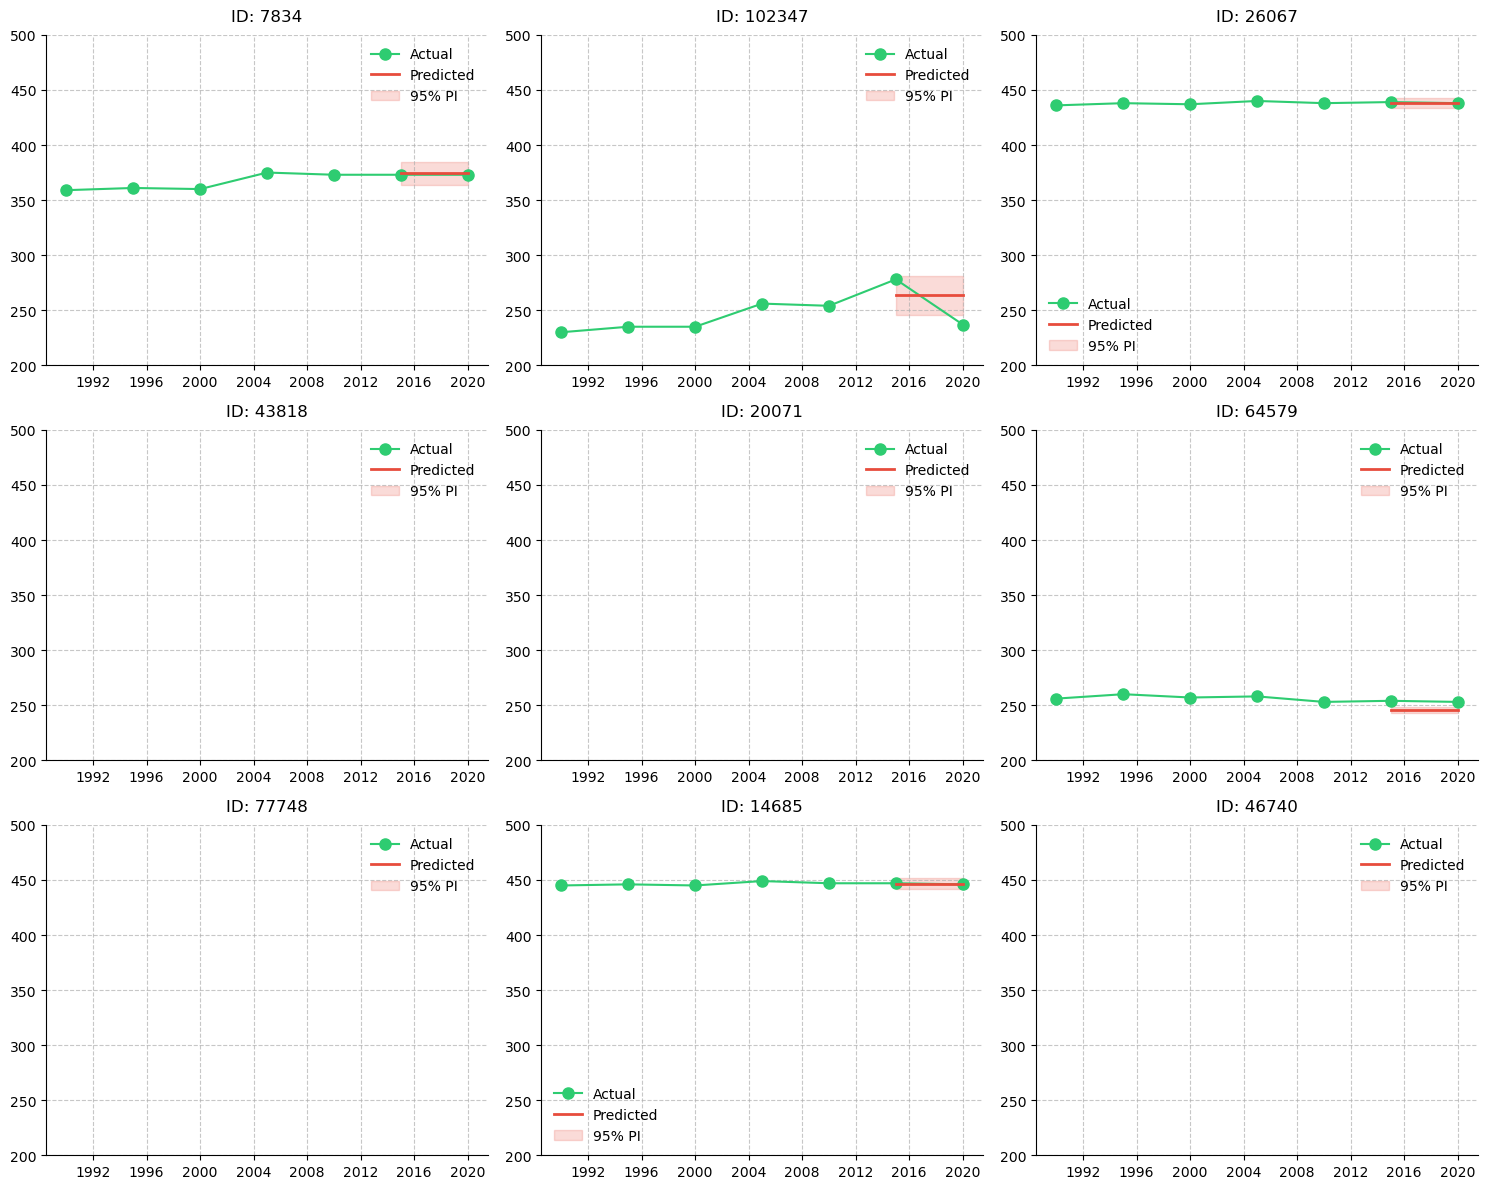

In [8]:
# Create a figure with subplots arranged in 3 columns
unique_ids = predsp['unique_id'].unique()
n_ids = len(unique_ids)
n_cols = 3
n_rows = (n_ids + n_cols - 1) // n_cols  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

# Plot each unique_id in its own subplot
for i, unique_id in enumerate(unique_ids):
    data = predsp[predsp['unique_id'] == unique_id]
    
    axes[i].plot(data['ds'], data['y'], 'o-', color='#2ecc71', label='Actual', markersize=8)
    # Plot prediction line
    axes[i].plot(data['ds'], data['LGBMRegressor'], '-', color='#e74c3c', label='Predicted', linewidth=2)
    
    # Fill confidence interval
    axes[i].fill_between(data['ds'], 
                        data['LGBMRegressor-lo-95'],
                        data['LGBMRegressor-hi-95'],
                        color='#e74c3c', alpha=0.2, label='95% PI')
    
    # Customize each subplot
    axes[i].set_ylim(200, 500)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].set_title(f'ID: {unique_id}', pad=10)
    axes[i].legend(frameon=False)
    axes[i].grid(True, linestyle='--', alpha=0.7)

# Hide empty subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [14]:
best_model = 'LGBMRegressor'
plot_data = preds[['unique_id', 'ds', 'y', 'LGBMRegressor','Naive']]
plot_data['ds'] = pd.to_datetime(plot_data['ds'], unit='ns').dt.year
#filter to years 2010,2015,2020
plot_data = plot_data[plot_data['ds'].isin([2010,2015,2020])]
# Sort by 'id' and 'year' to ensure proper order
plot_data = plot_data.sort_values(by=['unique_id', 'ds'])

# Calculate the difference in 'y' for each 'id'
plot_data['y_diff'] = plot_data['y'] - plot_data.groupby('unique_id')['y'].transform('first')
plot_data['n_diff'] = plot_data['Naive'] - plot_data.groupby('unique_id')['y'].transform('first')
plot_data['l_diff'] = plot_data['LGBMRegressor'] - plot_data.groupby('unique_id')['y'].transform('first')

#filter out ds = 2010
plot_data = plot_data[plot_data['ds'] != 2010]
plot_data

/var/folders/83/_9x1vwtd7ys516xdtt8y0pg40000gn/T/ipykernel_81308/3931832989.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['ds'] = pd.to_datetime(plot_data['ds'], unit='ns').dt.year


,unique_id,ds,y,LGBMRegressor,Naive,y_diff,n_diff,l_diff
19837,82,2015,4992.0,5057.745000,5002.0,0.0,10.0,65.745000
116232,82,2020,5781.0,5268.504532,5012.0,789.0,20.0,276.504532
19838,83,2015,4938.0,5073.458363,4954.0,0.0,16.0,135.458363
116233,83,2020,4973.0,5284.217895,4970.0,35.0,32.0,346.217895
19839,84,2015,2144.0,2216.733167,2167.0,1.0,24.0,73.733167
...,...,...,...,...,...,...,...,...
205795,122514,2020,1259.0,1692.401938,2001.0,-220.0,522.0,213.401938
113122,122515,2015,4620.0,5104.819970,4896.0,74.0,350.0,558.819970
205796,122515,2020,4825.0,5488.707648,5246.0,279.0,700.0,942.707648
113123,122516,2015,6815.0,6706.088207,6517.0,466.0,168.0,357.088207


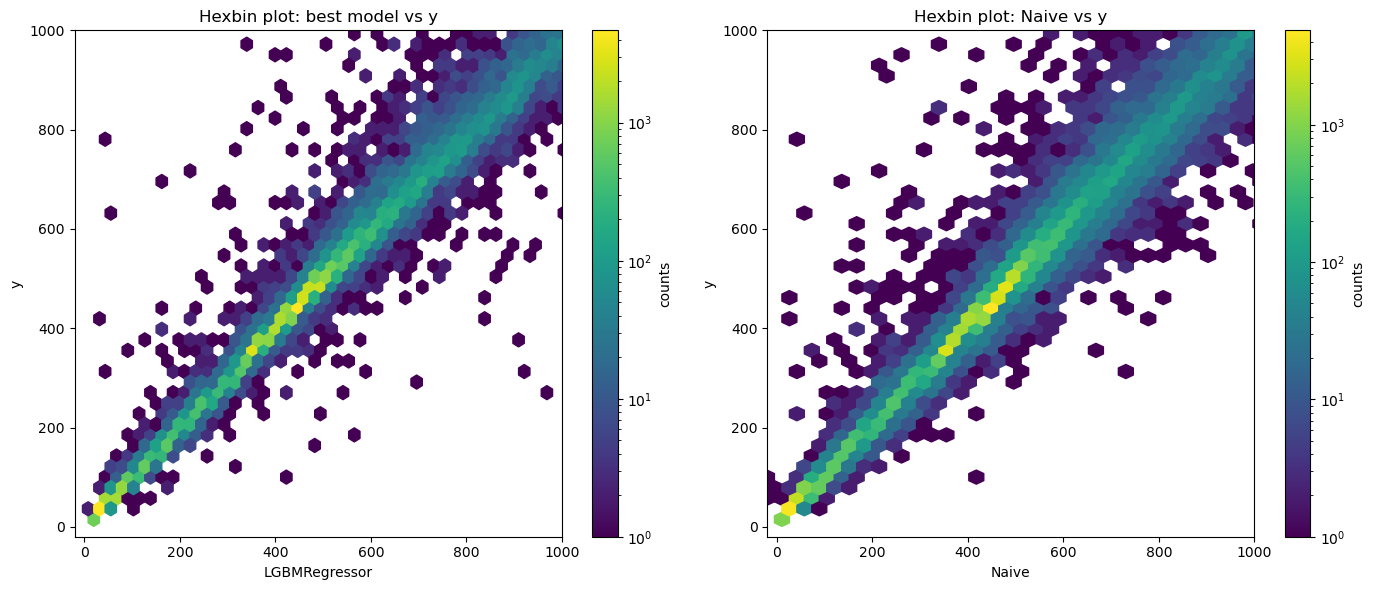

In [15]:
#filter out ds = 2010
hex_df = plot_data[plot_data['ds'] == 2015]

hex_df = hex_df[[best_model,'Naive','y']]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Hexbin plot for LGBMRegressor2 vs y
hb1 = axs[0].hexbin(hex_df[best_model], hex_df['y'], bins='log', gridsize=400, cmap='viridis')
axs[0].set_xlabel(best_model)
axs[0].set_ylabel('y')
axs[0].set_title('Hexbin plot: best model vs y')
axs[0].set_xlim(-20, 1000)
axs[0].set_ylim(-20, 1000)
cb1 = fig.colorbar(hb1, ax=axs[0], label='counts')

# Hexbin plot for Naive vs y
hb2 = axs[1].hexbin(hex_df['Naive'], hex_df['y'], bins='log', gridsize=400, cmap='viridis')
axs[1].set_xlabel('Naive')
axs[1].set_ylabel('y')
axs[1].set_title('Hexbin plot: Naive vs y')
axs[1].set_xlim(-20, 1000)
axs[1].set_ylim(-20, 1000)
cb2 = fig.colorbar(hb2, ax=axs[1], label='counts')

plt.tight_layout()
plt.show()

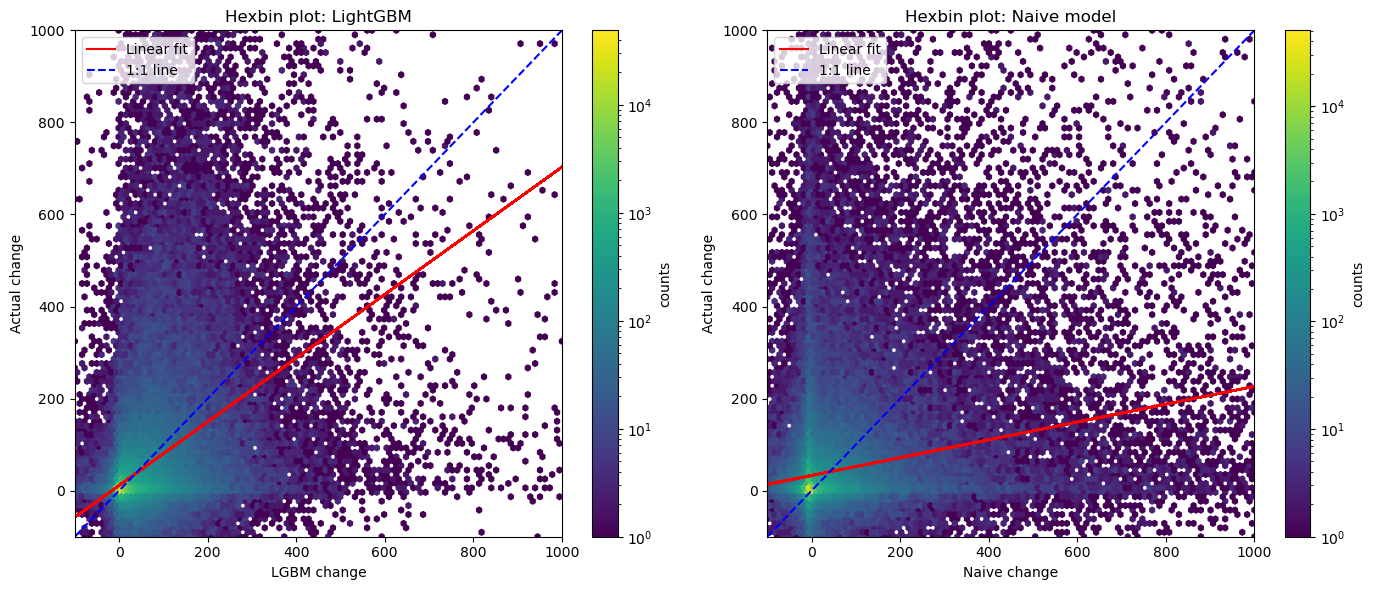

In [16]:
hex_df = plot_data[['l_diff','n_diff','y_diff']]

min_val = -100
max_val = 1000
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Hexbin plot for lgb_diff vs diff
hb1 = axs[0].hexbin(hex_df['l_diff'], hex_df['y_diff'], extent=(min_val, max_val, min_val, max_val), bins='log', gridsize=100, cmap='viridis')
axs[0].set_xlabel('LGBM change')
axs[0].set_ylabel('Actual change')
axs[0].set_title('Hexbin plot: LightGBM')
axs[0].set_xlim(min_val, max_val)
axs[0].set_ylim(min_val, max_val)
cb1 = fig.colorbar(hb1, ax=axs[0], label='counts')

# Linear fit for lgb_diff vs diff
m, b = np.polyfit(hex_df['l_diff'], hex_df['y_diff'], 1)
axs[0].plot(hex_df['l_diff'], m*hex_df['l_diff'] + b, color='red', label='Linear fit')
axs[0].plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', label='1:1 line')
axs[0].legend()

# Hexbin plot for n_diff vs diff
hb2 = axs[1].hexbin(hex_df['n_diff'], hex_df['y_diff'], extent=(min_val, max_val, min_val, max_val), bins='log', gridsize=100, cmap='viridis')
axs[1].set_xlabel('Naive change')
axs[1].set_ylabel('Actual change')
axs[1].set_title('Hexbin plot: Naive model')
axs[1].set_xlim(min_val, max_val)
axs[1].set_ylim(min_val, max_val)
cb2 = fig.colorbar(hb2, ax=axs[1], label='counts')

# Linear fit for n_diff vs diff
m, b = np.polyfit(hex_df['n_diff'], hex_df['y_diff'], 1)
axs[1].plot(hex_df['n_diff'], m*hex_df['n_diff'] + b, color='red', label='Linear fit')
axs[1].plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', label='1:1 line')
axs[1].legend()

plt.tight_layout()
plt.show()

In [5]:
#if we need to save
#dir = 'models/'
#fcst.save(dir)

#loaded = MLForecast.load(f'{dir}')
#print(loaded)

,ds,unique_id,y,elevation,AG,BU,HI,PO,EX,FR,...,sh_1,sh_2,sh_3,sh_4,sh_5,sh_6,sh_7,sh_8,gdp,lag1_mean
82,0,82,4980.0,0.000000,29.0,5084.0,0.0,0.0,117.0,0.0,...,0.247398,-0.153575,-0.392353,-0.444225,-0.173879,-0.221915,0.275758,0.212199,0.0,NaN
83,0,83,3628.0,0.000000,69.0,2999.0,0.0,0.0,173.0,0.0,...,0.247386,-0.153648,-0.392333,-0.444179,-0.173953,-0.221826,0.275874,0.212177,0.0,NaN
84,0,84,1371.0,11.240000,1244.0,0.0,0.0,0.0,111.0,0.0,...,0.247373,-0.153721,-0.392312,-0.444133,-0.174026,-0.221737,0.275991,0.212155,5341528.5,NaN
85,0,85,2089.0,28.464001,1993.0,0.0,0.0,0.0,84.0,0.0,...,0.247360,-0.153794,-0.392292,-0.444087,-0.174100,-0.221649,0.276107,0.212133,5341528.5,NaN
86,0,86,593.0,65.845596,449.0,0.0,0.0,0.0,113.0,0.0,...,0.247347,-0.153867,-0.392271,-0.444041,-0.174173,-0.221560,0.276224,0.212110,5341528.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167745,4,122512,1752.0,0.000000,125.0,0.0,0.0,0.0,267.0,0.0,...,0.262318,-0.166843,-0.376942,-0.452513,-0.200293,-0.205066,0.287814,0.167668,0.0,1426.0
1167746,4,122513,3398.0,0.403200,271.0,0.0,0.0,0.0,310.0,0.0,...,0.262303,-0.166916,-0.376920,-0.452462,-0.200368,-0.204970,0.287922,0.167649,0.0,1426.0
1167747,4,122514,1479.0,9.244800,366.0,0.0,0.0,0.0,410.0,0.0,...,0.262288,-0.166988,-0.376898,-0.452410,-0.200444,-0.204875,0.288030,0.167630,0.0,1426.0
1167748,4,122515,4546.0,17.409599,366.0,254.0,0.0,0.0,570.0,0.0,...,0.262273,-0.167060,-0.376877,-0.452358,-0.200519,-0.204779,0.288138,0.167611,0.0,2888.0


# fit and predict

In [9]:
fcst = MLForecast(
    models=lgb.LGBMRegressor(n_jobs=1, random_state=0, verbosity=-1),
    freq=1,
    lags=[1,2]
)
#df_values = df_values.drop(columns=['lag1_mean'])

fcst.fit(df_values, static_features=['elevation','AG', 'BU', 'HI', 'PO', 'EX', 'FR', 'TI', 'NS',
                                  'sh_0', 'sh_1', 'sh_2', 'sh_3','sh_4', 'sh_5', 'sh_6', 'sh_7', 'sh_8'],
                                  prediction_intervals=PredictionIntervals(n_windows=2, h=2))

MLForecast(models=[LGBMRegressor], freq=1, lag_features=['lag1', 'lag2'], date_features=[], num_threads=1)

In [10]:
#get original ids
ids = pd.Series(fcst.ts.uids)
lfa = LagFeatureAdder(df_ind, ids)

#filter df_dynamic to only include unique_ids in df_values
unique_ids = df_values['unique_id'].unique()
df_dynamic = df_dynamic[df_dynamic['unique_id'].isin(unique_ids)]
df_dynamic['lag1_mean'] = np.nan
df_dynamic

#filter df_dynamic to only include unique_ids in df_values
unique_ids = df_values['unique_id'].unique()
df_dynamic = df_dynamic[df_dynamic['unique_id'].isin(unique_ids)]

#predict
preds = fcst.predict(h=2, X_df=df_dynamic, level=[95],before_predict_callback=lfa.add_lag_features)

/Users/glen.moncrieff/mambaforge/envs/earthmover/lib/python3.12/site-packages/mlforecast/core.py:625: UserWarning: Found null values in lag1_mean.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')


0


/Users/glen.moncrieff/mambaforge/envs/earthmover/lib/python3.12/site-packages/mlforecast/core.py:625: UserWarning: Found null values in lag1_mean.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')


0


In [11]:
# Sample 5 random unique IDs
random_ids = preds['unique_id'].unique()
np.random.seed(42) # For reproducibility
sampled_ids = np.random.choice(random_ids, size=9, replace=False)
# Filter predictions to only include sampled IDs
predsp = preds[preds['unique_id'].isin(sampled_ids)]
df_valuesp = df_values[df_values['unique_id'].isin(sampled_ids)]
#order by date
predsp = predsp.sort_values(by='ds')


#join with predictions
predsp = predsp.merge(df_valuesp[['unique_id', 'ds', 'y']], left_on=['unique_id', 'ds'], right_on=['unique_id', 'ds'], how='outer')
#convert ds to years by multiplying by 5 and adding 1990
years = (predsp['ds'] * 5) + 1990
predsp['ds'] = pd.to_datetime(years.astype(str) + '-01-01')

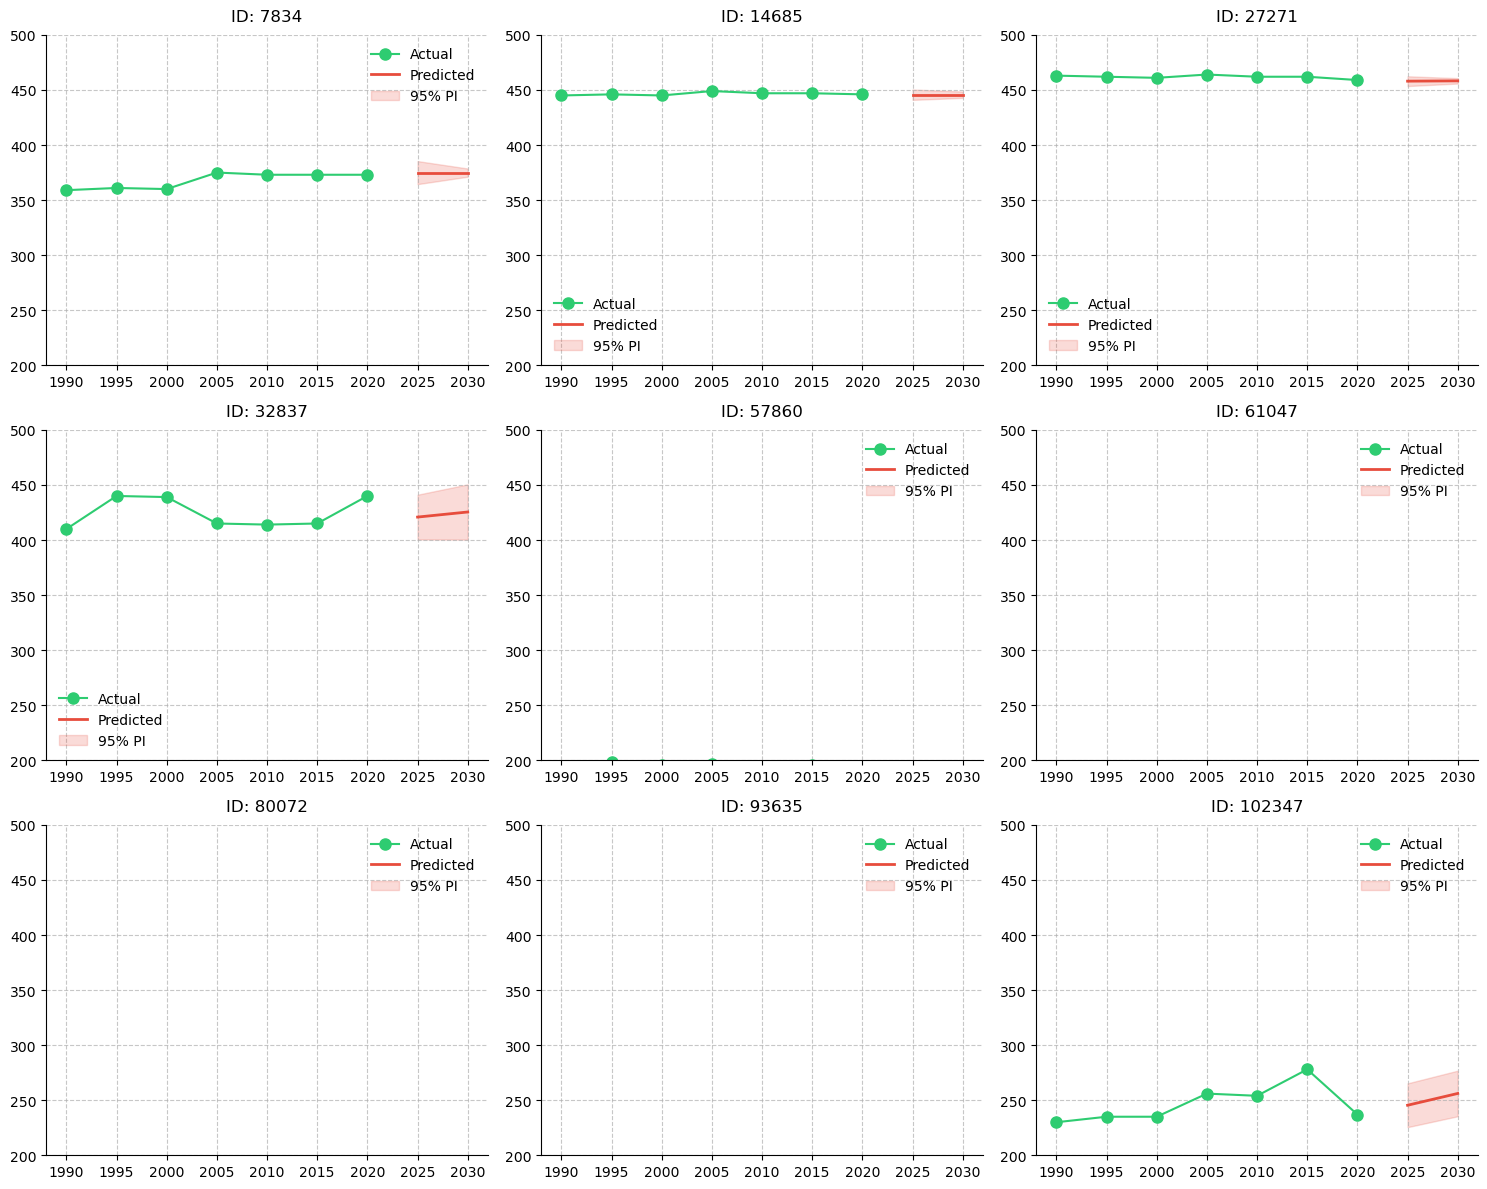

In [12]:
# Create a figure with subplots arranged in 3 columns
unique_ids = predsp['unique_id'].unique()
n_ids = len(unique_ids)
n_cols = 3
n_rows = (n_ids + n_cols - 1) // n_cols  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

# Plot each unique_id in its own subplot
for i, unique_id in enumerate(unique_ids):
    data = predsp[predsp['unique_id'] == unique_id]
    


    axes[i].plot(data['ds'], data['y'], 'o-', color='#2ecc71', label='Actual', markersize=8)
    # Plot prediction line
    axes[i].plot(data['ds'], data['LGBMRegressor'], '-', color='#e74c3c', label='Predicted', linewidth=2)
    
    # Fill confidence interval
    axes[i].fill_between(data['ds'], 
                        data['LGBMRegressor-lo-95'],
                        data['LGBMRegressor-hi-95'],
                        color='#e74c3c', alpha=0.2, label='95% PI')
    
    
    # Customize each subplot
    axes[i].set_ylim(200, 500)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].set_title(f'ID: {unique_id}', pad=10)
    axes[i].legend(frameon=False)
    axes[i].grid(True, linestyle='--', alpha=0.7)

# Hide empty subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# explain model

In [20]:
fcst.preprocess(df_values,static_features=['elevation','AG', 'BU', 'HI', 'PO', 'EX', 'FR', 'TI', 'NS','sh_0', 'sh_1', 'sh_2', 'sh_3','sh_4', 'sh_5', 'sh_6', 'sh_7', 'sh_8'])

,ds,unique_id,y,elevation,AG,BU,HI,PO,EX,FR,...,sh_3,sh_4,sh_5,sh_6,sh_7,sh_8,gdp,lag1_mean,lag1,lag2
28423,5,82,4992.0,0.000000,29.0,5084.0,0.0,0.0,117.0,0.0,...,-0.392353,-0.444225,-0.173879,-0.221915,0.275758,0.212199,0.0,4992.000000,4992.0,4982.0
28424,5,83,4938.0,0.000000,69.0,2999.0,0.0,0.0,173.0,0.0,...,-0.392333,-0.444179,-0.173953,-0.221826,0.275874,0.212177,0.0,2729.428467,4938.0,4922.0
28425,5,84,2144.0,11.240000,1244.0,0.0,0.0,0.0,111.0,0.0,...,-0.392312,-0.444133,-0.174026,-0.221737,0.275991,0.212155,10158768.0,2729.428467,2143.0,2119.0
28426,5,85,2108.0,28.464001,1993.0,0.0,0.0,0.0,84.0,0.0,...,-0.392292,-0.444087,-0.174100,-0.221649,0.276107,0.212133,10158768.0,2729.428467,2106.0,2091.0
28427,5,86,2081.0,65.845596,449.0,0.0,0.0,0.0,113.0,0.0,...,-0.392271,-0.444041,-0.174173,-0.221560,0.276224,0.212110,10158768.0,2081.000000,2081.0,593.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167745,4,122512,1752.0,0.000000,125.0,0.0,0.0,0.0,267.0,0.0,...,-0.376942,-0.452513,-0.200293,-0.205066,0.287814,0.167668,0.0,1426.000000,1525.0,1522.0
1167746,4,122513,3398.0,0.403200,271.0,0.0,0.0,0.0,310.0,0.0,...,-0.376920,-0.452462,-0.200368,-0.204970,0.287922,0.167649,0.0,1426.000000,2570.0,2567.0
1167747,4,122514,1479.0,9.244800,366.0,0.0,0.0,0.0,410.0,0.0,...,-0.376898,-0.452410,-0.200444,-0.204875,0.288030,0.167630,0.0,1426.000000,1218.0,1214.0
1167748,4,122515,4546.0,17.409599,366.0,254.0,0.0,0.0,570.0,0.0,...,-0.376877,-0.452358,-0.200519,-0.204779,0.288138,0.167611,0.0,2888.000000,4196.0,1971.0


In [15]:
import shap

#extract features
prep = fcst.preprocess(df_values,static_features=['elevation','AG', 'BU', 'HI', 'PO', 'EX', 'FR', 'TI', 'NS','sh_0', 'sh_1', 'sh_2', 'sh_3','sh_4', 'sh_5', 'sh_6', 'sh_7', 'sh_8'])
X = prep.drop(columns=['unique_id', 'ds', 'y'])

#explain the model
X100 = shap.utils.sample(X, 100)
explainer = shap.TreeExplainer(fcst.models_['LGBMRegressor'], X100)
shap_values = explainer(X)


100%|===================| 437536/437700 [08:21<00:00]        

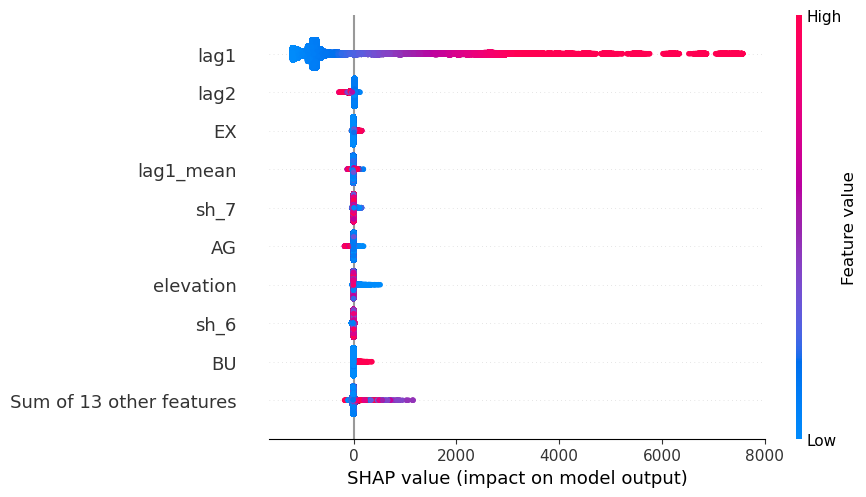

In [44]:

#plot beeswarm to expalin all obs and rank features importantce
shap.plots.beeswarm(shap_values)


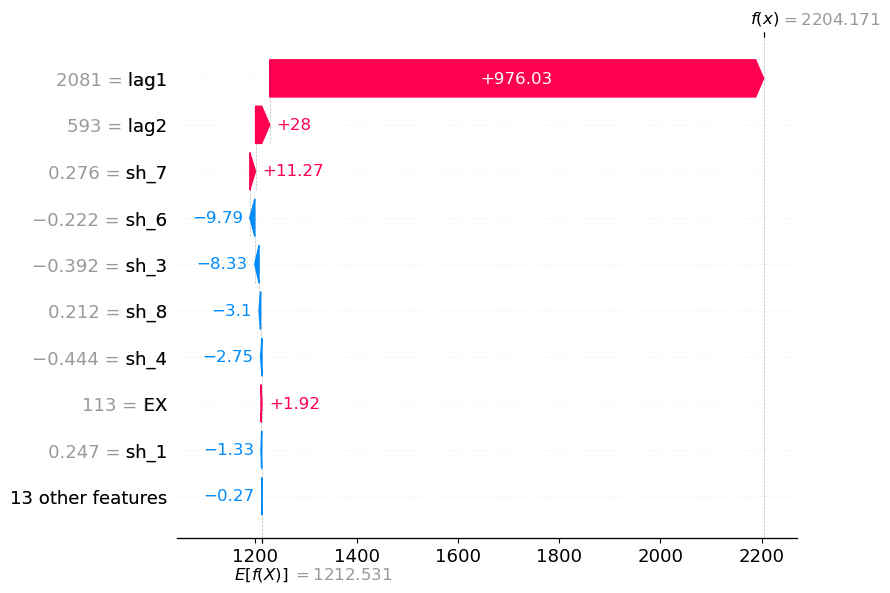

In [45]:

#explain a single obs
shap.plots.waterfall(shap_values[4])


In [47]:

#get the shap values for particular features
ele = shap_values.values[:,0]
locs = shap_values.values[:,-13:-4]

#sum all latlong shap values
tloc = locs.sum(axis=-1)

#create a new df with shap values
shap_df = pd.DataFrame({'shap': tloc, 'unique_id': prep['unique_id']})

#group by unique_id and take the mean shap value
shap_df = shap_df.groupby('unique_id').mean().reset_index()

# recreate xarray

In [48]:
years = (preds['ds'] * 5) + 1990

# Create a datetime column with vectorized operation
preds['ds'] = pd.to_datetime(years.astype(str) + '-01-01')

#add shap values to preds
#shap_df = shap_df.drop_duplicates(subset=['unique_id'])
preds = preds.merge(shap_df, on='unique_id', how='left')
preds


,unique_id,ds,LGBMRegressor,LGBMRegressor-lo-95,LGBMRegressor-hi-95,shap
0,82,2025-01-01,6201.470002,6104.133579,6298.806426,-17.532367
1,82,2030-01-01,6202.268514,5547.316974,6857.220054,-17.532367
2,83,2025-01-01,5023.801995,4539.328316,5508.275674,-19.561938
3,83,2030-01-01,5197.758621,4317.276236,6078.241006,-19.561938
4,84,2025-01-01,2262.733355,1899.831482,2625.635228,-17.084685
...,...,...,...,...,...,...
175075,122514,2030-01-01,1420.374852,1151.728445,1689.021260,57.948309
175076,122515,2025-01-01,5016.109638,3044.953643,6987.265632,111.780056
175077,122515,2030-01-01,5279.874806,3090.675618,7469.073993,111.780056
175078,122516,2025-01-01,7539.376763,6590.816161,8487.937366,64.844530


In [49]:
#rename cols in preds
preds = preds.rename(columns={'ds': 'time', 'unique_id': 'v','LGBMRegressor': 'val'})


In [50]:
dv = xr.open_dataset('data/test/hm_coord.zarr')
#name the variable
dv = dv.rename_vars({'__xarray_dataarray_variable__': 'HM'})
#rename dim z to v
dv = dv.swap_dims({"z": "v"})
dv



<xarray.Dataset> Size: 4MB
Dimensions:    (v: 130284)
Coordinates:
    latitude   (v) float64 1MB ...
    longitude  (v) float64 1MB ...
  * v          (v) int64 1MB 0 1 2 3 4 5 ... 130279 130280 130281 130282 130283
Data variables:
    HM         (v) int64 1MB ...
Attributes:
    __xarray_dataarray_name__:  v

In [51]:
#turns preds to xr
# Pivot to create a time dimension for each variable
df_pivot1 = preds.pivot(index='v', columns='time', values='val')
df_pivot2 = preds.pivot(index='v', columns='time', values='LGBMRegressor-hi-95')
df_pivot3 = preds.pivot(index='v', columns='time', values='LGBMRegressor-lo-95')
df_pivot4 = preds.pivot(index='v', columns='time', values='shap')
# Convert to xarray dataset with multiple variables
dt = xr.Dataset(
    data_vars={
        'HM': (['v', 'time'], df_pivot1),
        'HMhi': (['v', 'time'], df_pivot2), 
        'HMlo': (['v', 'time'], df_pivot3),
        'shap': (['v', 'time'], df_pivot4)
    },
    coords={
        'v': df_pivot1.index,
        'time': df_pivot1.columns
    }
)
dt

<xarray.Dataset> Size: 6MB
Dimensions:  (v: 87540, time: 2)
Coordinates:
  * v        (v) int64 700kB 82 83 84 85 86 ... 122513 122514 122515 122516
  * time     (time) datetime64[ns] 16B 2025-01-01 2030-01-01
Data variables:
    HM       (v, time) float64 1MB 6.201e+03 6.202e+03 ... 7.539e+03 7.539e+03
    HMhi     (v, time) float64 1MB 6.299e+03 6.857e+03 ... 8.488e+03 8.368e+03
    HMlo     (v, time) float64 1MB 6.104e+03 5.547e+03 ... 6.591e+03 6.711e+03
    shap     (v, time) float64 1MB -17.53 -17.53 -19.56 ... 111.8 64.84 64.84

In [52]:
dm = xr.Dataset({
    'dv': dv['HM'],  # Add the variable from dv
    'dt': dt['HM'],
    'dt_hi': dt['HMhi'],
    'dt_lo': dt['HMlo'],
    'shap': dt['shap']
})
dm

<xarray.Dataset> Size: 13MB
Dimensions:    (v: 130284, time: 2)
Coordinates:
  * v          (v) int64 1MB 0 1 2 3 4 5 ... 130279 130280 130281 130282 130283
    latitude   (v) float64 1MB ...
    longitude  (v) float64 1MB ...
  * time       (time) datetime64[ns] 16B 2025-01-01 2030-01-01
Data variables:
    dv         (v) int64 1MB ...
    dt         (v, time) float64 2MB nan nan nan nan nan ... nan nan nan nan nan
    dt_hi      (v, time) float64 2MB nan nan nan nan nan ... nan nan nan nan nan
    dt_lo      (v, time) float64 2MB nan nan nan nan nan ... nan nan nan nan nan
    shap       (v, time) float64 2MB nan nan nan nan nan ... nan nan nan nan nan

In [53]:
dxy = dm.set_index(v=['latitude', 'longitude'])
dxy = dxy.unstack('v')

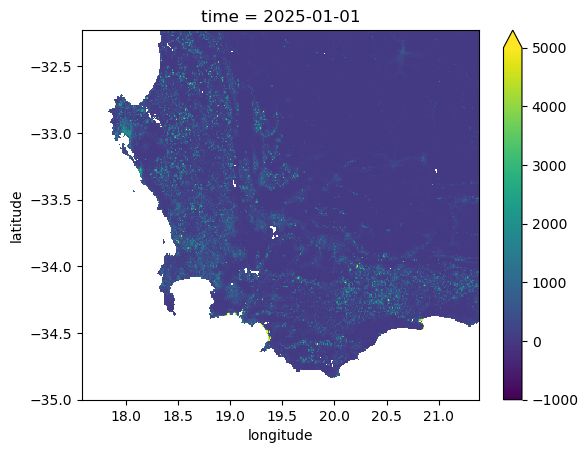

In [54]:
#dxy['dt'].isel(time=0).plot(cmap='viridis', vmin=0, vmax=8000)

dp = dxy['dt_hi']-dxy['dt_lo']
dp.isel(time=0).plot(cmap='viridis', vmin=-1000, vmax=5000)


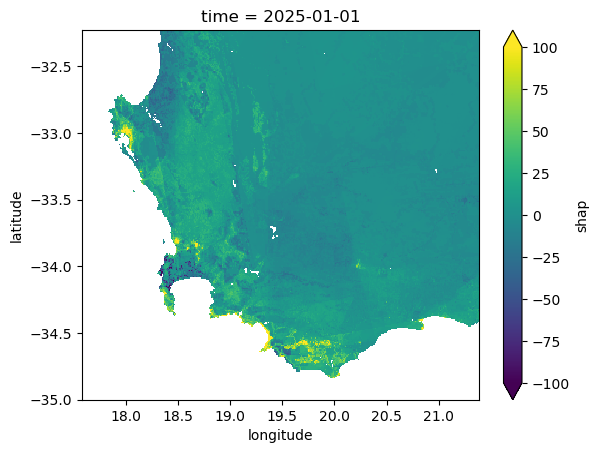

In [55]:

dp = dxy['shap']
dp.isel(time=0).plot(cmap='viridis', vmin=-100, vmax=100)